In [ ]:
import os
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import  Dataset, DataLoader
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

## Reading data

In [18]:
def load_imdb_data(data_dir):
    data = {'review': [], 'sentiment': [], 'split': []}
    for split in ['train', 'test']:
        for sentiment in ['pos', 'neg']:
            path = os.path.join(data_dir, split, sentiment)
            for fname in os.listdir(path):
                if fname.endswith(".txt"):
                    with open(os.path.join(path, fname), encoding='utf-8') as f:
                        data['review'].append(f.read())
                        data['sentiment'].append(1 if sentiment == 'pos' else 0)
                        data['split'].append(split)
    return pd.DataFrame(data)

# Read all data into dataframe
imdb_df = load_imdb_data('aclImdb')

# Save to csv for future usage
# imdb_df.to_csv("imdb_raws.csv", index=False)

imdb_df

,review,sentiment,split
0,Bromwell High is a cartoon comedy. It ran at t...,1,train
1,Homelessness (or Houselessness as George Carli...,1,train
2,Brilliant over-acting by Lesley Ann Warren. Be...,1,train
3,This is easily the most underrated film inn th...,1,train
4,This is not the typical Mel Brooks film. It wa...,1,train
...,...,...,...
49995,I occasionally let my kids watch this garbage ...,0,test
49996,When all we have anymore is pretty much realit...,0,test
49997,The basic genre is a thriller intercut with an...,0,test
49998,Four things intrigued me as to this film - fir...,0,test


In [40]:
imdb_df['split'].value_counts()

split
train    25000
test     25000
Name: count, dtype: int64

In [2]:
imdb_df = pd.read_csv('imdb_raws.csv')
imdb_df

,review,sentiment,split
0,Bromwell High is a cartoon comedy. It ran at t...,1,train
1,Homelessness (or Houselessness as George Carli...,1,train
2,Brilliant over-acting by Lesley Ann Warren. Be...,1,train
3,This is easily the most underrated film inn th...,1,train
4,This is not the typical Mel Brooks film. It wa...,1,train
...,...,...,...
49995,I occasionally let my kids watch this garbage ...,0,test
49996,When all we have anymore is pretty much realit...,0,test
49997,The basic genre is a thriller intercut with an...,0,test
49998,Four things intrigued me as to this film - fir...,0,test


In [69]:
# Sample half of test data into train data
test_pos = imdb_df[(imdb_df['split'] == 'test') & (imdb_df['sentiment'] == 1)]
test_neg = imdb_df[(imdb_df['split'] == 'test') & (imdb_df['sentiment'] == 0)]

sampled_pos = test_pos.sample(n=6250, random_state=42)
sampled_neg = test_neg.sample(n=6250, random_state=42)

sampled_test = pd.concat([sampled_pos, sampled_neg])
sampled_test['split'] = 'train'
print(f"Sampled test length: {len(sampled_test)}\n{sampled_test.groupby(['split', 'sentiment']).size()}\n")

remaining_test = imdb_df[~imdb_df.index.isin(sampled_test.index)]#[imdb_df['split'] == 'test']
remaining_test = remaining_test[remaining_test['split'] == 'test']
print(f"Remaining test length: {len(remaining_test)}\n{remaining_test.groupby(['split', 'sentiment']).size()}\n")

imdb_df = pd.concat([remaining_test, imdb_df[imdb_df['split'] == 'train'], sampled_test], ignore_index=True)
# imdb_df.to_csv("imdb_more_train.csv", index=False)

print("IMDB:")
print(imdb_df.groupby(['split', 'sentiment']).size())

Sampled test length: 12500
split  sentiment
train  0            6250
       1            6250
dtype: int64

Remaining test length: 12500
split  sentiment
test   0            6250
       1            6250
dtype: int64

IMDB:
split  sentiment
test   0             6250
       1             6250
train  0            18750
       1            18750
dtype: int64


In [3]:
imdb_df = pd.read_csv('imdb_more_train.csv')
imdb_df

,review,sentiment,split
0,Actor turned director Bill Paxton follows up h...,1,test
1,As a recreational golfer with some knowledge o...,1,test
2,Bill Paxton has taken the true story of the 19...,1,test
3,"I saw this film on September 1st, 2005 in Indi...",1,test
4,"Maybe I'm reading into this too much, but I wo...",1,test
...,...,...,...
49995,"I had high hopes for this production, being on...",0,train
49996,Positively ridiculous film.<br /><br />If Dori...,0,train
49997,I had a bit of hope for this hour long film ma...,0,train
49998,The Lifetime channel aired this in October but...,0,train


In [4]:
imdb_df_train = imdb_df[imdb_df['split'] == 'train'].copy().reset_index(drop=True)
imdb_df_test = imdb_df[imdb_df['split'] == 'test'].copy().reset_index(drop=True)
len(imdb_df_train), len(imdb_df_test)

(37500, 12500)

## Data Preprocessing

In [5]:
stop_words = set(stopwords.words('english'))

def clean_and_tokenize(text, remove_stopwords=False):
  # Replace HTML tags
  text = text.replace('<br />', ' ').replace('<br></br>', ' ')
    
  # Lowercase
  text = text.lower()
    
  # Remove non-alphabetic characters
  text = re.sub(r"[^a-zA-Z]", ' ', text)
    
  # Tokenize
  tokens = word_tokenize(text)
    
  # Remove stopwords
  if remove_stopwords:
    tokens = [t for t in tokens if t not in stop_words]
    
  return tokens

In [6]:
# Apply to DataFrame to add new column
imdb_df_train['tokens'] = imdb_df_train['review'].apply(lambda x: clean_and_tokenize(x, remove_stopwords=True))
imdb_df_train

,review,sentiment,split,tokens
0,Bromwell High is a cartoon comedy. It ran at t...,1,train,"[bromwell, high, cartoon, comedy, ran, time, p..."
1,Homelessness (or Houselessness as George Carli...,1,train,"[homelessness, houselessness, george, carlin, ..."
2,Brilliant over-acting by Lesley Ann Warren. Be...,1,train,"[brilliant, acting, lesley, ann, warren, best,..."
3,This is easily the most underrated film inn th...,1,train,"[easily, underrated, film, inn, brooks, cannon..."
4,This is not the typical Mel Brooks film. It wa...,1,train,"[typical, mel, brooks, film, much, less, slaps..."
...,...,...,...,...
37495,"I had high hopes for this production, being on...",0,train,"[high, hopes, production, one, favourite, work..."
37496,Positively ridiculous film.<br /><br />If Dori...,0,train,"[positively, ridiculous, film, doris, roberts,..."
37497,I had a bit of hope for this hour long film ma...,0,train,"[bit, hope, hour, long, film, made, footage, o..."
37498,The Lifetime channel aired this in October but...,0,train,"[lifetime, channel, aired, october, got, aroun..."


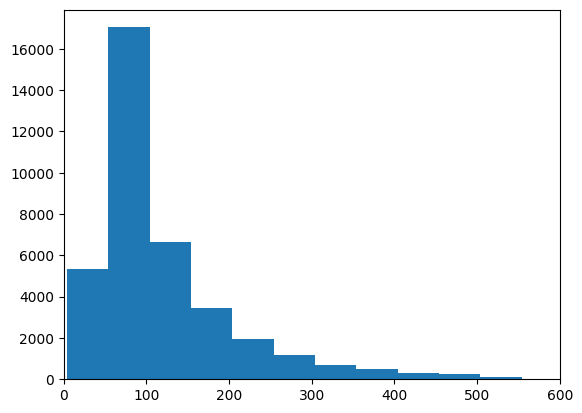

In [87]:
# Plot histogram to see review length distribution
review_length_train = imdb_df_train['tokens'].apply(lambda x: len(x))

bin_width = 50
bins_train = np.arange(min(review_length_train), max(review_length_train) + bin_width, bin_width)

plt.hist(review_length_train, bins=bins_train)
plt.xlim(0, 600)
plt.show()

In [88]:
review_length_train.describe()

count    37500.000000
mean       118.663893
std         89.956809
min          4.000000
25%         63.000000
50%         88.000000
75%        144.000000
max       1422.000000
Name: tokens, dtype: float64

In [7]:
# Apply to DataFrame to add new column
imdb_df_test['tokens'] = imdb_df_test['review'].apply(lambda x: clean_and_tokenize(x, remove_stopwords=True))
imdb_df_test

,review,sentiment,split,tokens
0,Actor turned director Bill Paxton follows up h...,1,test,"[actor, turned, director, bill, paxton, follow..."
1,As a recreational golfer with some knowledge o...,1,test,"[recreational, golfer, knowledge, sport, histo..."
2,Bill Paxton has taken the true story of the 19...,1,test,"[bill, paxton, taken, true, story, us, golf, o..."
3,"I saw this film on September 1st, 2005 in Indi...",1,test,"[saw, film, september, st, indianapolis, one, ..."
4,"Maybe I'm reading into this too much, but I wo...",1,test,"[maybe, reading, much, wonder, much, hand, hon..."
...,...,...,...,...
12495,many people said this was a great movie with H...,0,test,"[many, people, said, great, movie, hoffman, de..."
12496,"Awful, awful, awful times a hundred still does...",0,test,"[awful, awful, awful, times, hundred, still, b..."
12497,I occasionally let my kids watch this garbage ...,0,test,"[occasionally, let, kids, watch, garbage, unde..."
12498,When all we have anymore is pretty much realit...,0,test,"[anymore, pretty, much, reality, tv, shows, pe..."


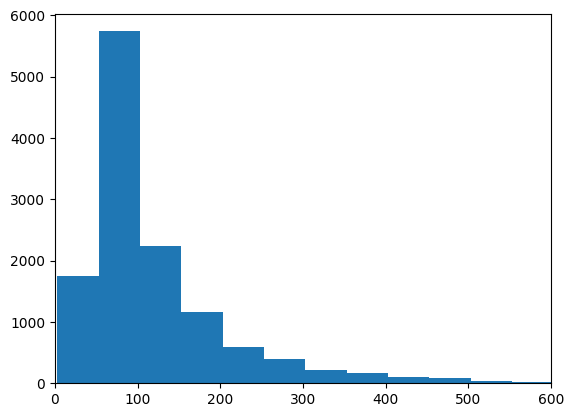

In [90]:
# Plot histogram to see review length distribution
review_length_test = imdb_df_test['tokens'].apply(lambda x: len(x))

bin_width = 50
bins_test = np.arange(min(review_length_test), max(review_length_test) + bin_width, bin_width)

plt.hist(review_length_test, bins=bins_test)
plt.xlim(0, 600)
plt.show()

In [91]:
review_length_test.describe()

count    12500.000000
mean       116.538560
std         87.658417
min          3.000000
25%         63.000000
50%         87.000000
75%        142.000000
max       1089.000000
Name: tokens, dtype: float64

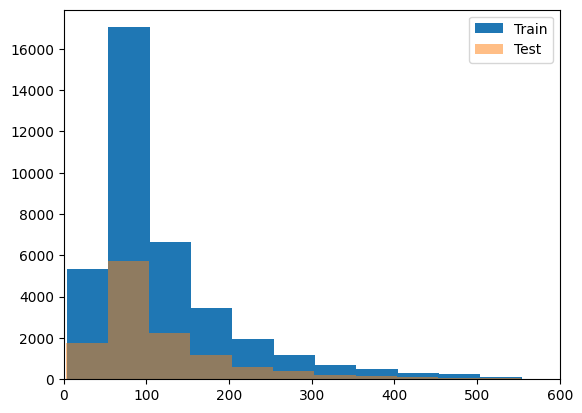

In [92]:
# Plot both histogram to see their difference
plt.hist(review_length_train, bins=bins_train, label="Train")
plt.hist(review_length_test, bins=bins_test, alpha=0.5, label="Test")
plt.xlim(0, 600)
plt.legend()
plt.show()

## Vocabulary

In [8]:
class Vocabulary:
  def __init__(self, token_to_index={}, pad_token='<pad>', unk_token='<unk>'):
    self.token_to_index = token_to_index

    if len(self.token_to_index) == 0:
      self.token_to_index[pad_token] = 0
      self.token_to_index[unk_token] = 1

    self.index_to_token = {index: token for token, index in self.token_to_index.items()}

    self.pad_token = pad_token
    self.pad_index = self.token_to_index[self.pad_token]

    self.unk_token = unk_token
    self.unk_index = self.token_to_index[self.unk_token]
  
  def __len__(self):
    return len(self.token_to_index)

  def add_token(self, token):
    if token in self.token_to_index:
      index = self.token_to_index[token]
    else:
      index = len(self.token_to_index)
      self.token_to_index[token] = index
      self.index_to_token[index] = token
    return index

  def lookup_token(self, token):
    return self.token_to_index.get(token, self.unk_index)
  
  def lookup_index(self, index):
    if index not in self.index_to_token:
      raise KeyError(f"the index {index} is not in the Vocabulary")
    return self.index_to_token[index]

  # Build vocab from tokenized data filtered by minimun frequency of each word
  @classmethod
  def build_vocab_with_min_freq(cls, token_lists, min_freq=25):
    counter = Counter()
    for tokens in token_lists:
      counter.update(tokens)
    
    # '<pad>' is for padding review to have the same length
    # '<unk>' is for unknown word that are removed or not in train data
    vocab = {'<pad>': 0, '<unk>': 1}
    
    for word, freq in counter.items():
      if freq >= min_freq:
        vocab[word] = len(vocab)
    
    return cls(vocab)

  # Build vocab from tokenized data filtered by maximun words in vocab
  @classmethod
  def build_vocab_with_max_words(cls, token_lists, max_words=8000):
    counter = Counter()
    for tokens in token_lists:
      counter.update(tokens)
    
    # '<pad>' is for padding review to have the same length
    # '<unk>' is for unknown word that are removed or not in train data
    vocab = {'<pad>': 0, '<unk>': 1}
  
    most_common_words = counter.most_common(max_words - 2)
    for word, _ in most_common_words:
      vocab[word] = len(vocab)

    return cls(vocab)

In [9]:
# Build vocabulary from train data
review_vocab = Vocabulary.build_vocab_with_max_words(imdb_df_train['tokens'])
len(review_vocab)

8000

## Vectorizer

In [10]:
class Vectorizer:
  def __init__(self, vocab: Vocabulary):
    self.vocab = vocab
    self.vocab_size = len(vocab)

  # Turn token into index for embedding
  def index_vectorize(self, token_list):
    indices = np.zeros(len(token_list), dtype=np.float32)
    for i, token in enumerate(token_list):
      index = self.vocab.lookup_token(token)
      indices[i] = index
    return indices

  # One-Hot encoder for Feedforward Neural Network
  def onehot_vectorize(self, token_list):
    onehot = np.zeros(self.vocab_size, dtype=np.float32)
    for token in token_list:
      index = self.vocab.lookup_token(token)
      onehot[index] += 1.0
    return onehot

In [11]:
review_vectorizer = Vectorizer(review_vocab)

In [12]:
# See example of index vectorize
review_vectorizer.index_vectorize(imdb_df_train['tokens'][0])

array([1.000e+00, 1.870e+02, 8.950e+02, 1.010e+02, 1.959e+03, 7.000e+00,
       6.013e+03, 2.510e+02, 3.500e+01, 5.070e+03, 5.800e+01, 4.195e+03,
       5.536e+03, 3.480e+02, 1.450e+02, 1.000e+00, 1.870e+02, 1.931e+03,
       1.400e+01, 2.343e+03, 4.690e+02, 5.070e+03, 1.000e+00, 1.782e+03,
       1.000e+00, 5.456e+03, 1.312e+03, 1.200e+01, 9.900e+01, 1.002e+03,
       5.070e+03, 1.000e+00, 1.000e+00, 1.150e+02, 7.280e+02, 2.976e+03,
       5.380e+03, 5.440e+02, 1.312e+03, 1.070e+02, 2.650e+02, 1.269e+03,
       3.292e+03, 6.410e+02, 3.320e+03, 2.510e+02, 1.087e+03, 1.000e+00,
       1.870e+02, 2.410e+02, 2.310e+02, 3.118e+03, 1.000e+00, 4.000e+00,
       5.070e+03, 1.269e+03, 2.251e+03, 1.000e+00, 1.870e+02, 3.880e+02,
       3.300e+01, 1.408e+03, 4.380e+02, 2.600e+01, 1.000e+00, 1.870e+02,
       1.180e+02, 4.097e+03, 2.130e+03], dtype=float32)

In [13]:
# See example of one hot vectorize
onehot = review_vectorizer.onehot_vectorize(imdb_df_train['tokens'][0])
onehot, list(filter(lambda x: x[-1] > 0, [(review_vocab.lookup_index(index), index, freq) for index, freq in enumerate(onehot)]))

(array([ 0., 10.,  0., ...,  0.,  0.,  0.], dtype=float32),
 [('<unk>', 1, np.float32(10.0)),
  ('one', 4, np.float32(1.0)),
  ('time', 7, np.float32(1.0)),
  ('see', 12, np.float32(1.0)),
  ('much', 14, np.float32(1.0)),
  ('think', 26, np.float32(1.0)),
  ('many', 33, np.float32(1.0)),
  ('life', 35, np.float32(1.0)),
  ('years', 58, np.float32(1.0)),
  ('right', 99, np.float32(1.0)),
  ('comedy', 101, np.float32(1.0)),
  ('saw', 107, np.float32(1.0)),
  ('whole', 115, np.float32(1.0)),
  ('far', 118, np.float32(1.0)),
  ('believe', 145, np.float32(1.0)),
  ('high', 187, np.float32(5.0)),
  ('line', 231, np.float32(1.0)),
  ('classic', 241, np.float32(1.0)),
  ('school', 251, np.float32(2.0)),
  ('episode', 265, np.float32(1.0)),
  ('lead', 348, np.float32(1.0)),
  ('expect', 388, np.float32(1.0)),
  ('age', 438, np.float32(1.0)),
  ('reality', 469, np.float32(1.0)),
  ('knew', 544, np.float32(1.0)),
  ('tried', 641, np.float32(1.0)),
  ('situation', 728, np.float32(1.0)),
  ('cartoo

## Dataset

In [14]:
class IndexReviewDataset(Dataset):
  def __init__(self, imdb_df, vectorizer: Vectorizer, max_length):
    self.review_df = imdb_df
    self.vectorizer = vectorizer
    self.max_length = max_length
    self.pad_index = vectorizer.vocab.pad_index

  def __len__(self):
    return len(self.review_df)

  def __getitem__(self, index):
    row = self.review_df.iloc[index]
    review_indices = self.vectorizer.index_vectorize(row.tokens[:self.max_length])
    padded = np.full(self.max_length, fill_value=self.pad_index)
    padded[:len(review_indices)] = review_indices
    sentiment_vector = row.sentiment
    return {'x': padded,
            'y': sentiment_vector}

  def get_vectorizer(self):
    return self.vectorizer 
  
  def get_num_batches(self, batch_size):
    return len(self) // batch_size 

In [15]:
index_dataset_train = IndexReviewDataset(imdb_df=imdb_df_train, vectorizer=review_vectorizer, max_length=300)
index_dataset_test = IndexReviewDataset(imdb_df=imdb_df_test, vectorizer=review_vectorizer, max_length=300)

In [16]:
class OneHotReviewDataset(Dataset):
  def __init__(self, imdb_df, vectorizer: Vectorizer):
    self.review_df = imdb_df
    self.vectorizer = vectorizer

  def __len__(self):
    return len(self.review_df)

  def __getitem__(self, index):
    row = self.review_df.iloc[index]
    review_vector = self.vectorizer.onehot_vectorize(row.tokens)
    sentiment_vector = row.sentiment
    return {'x': review_vector,
            'y': sentiment_vector}

  def get_vectorizer(self):
    return self.vectorizer 
  
  def get_num_batches(self, batch_size):
    return len(self) // batch_size 

In [17]:
onehot_dataset_train = OneHotReviewDataset(imdb_df=imdb_df_train, vectorizer=review_vectorizer)
onehot_dataset_test = OneHotReviewDataset(imdb_df=imdb_df_test, vectorizer=review_vectorizer)

## Dataloader

In [18]:
def generate_batches(dataset, batch_size, 
                     shuffle=True,
                     drop_last=True, 
                     device="cpu"):
  
  dataloader = DataLoader(dataset=dataset, 
                          batch_size=batch_size,
                          shuffle=shuffle, 
                          drop_last=drop_last)

  for data_dict in dataloader:
    out_data_dict = {}
    for name, tensor in data_dict.items():
      out_data_dict[name] = data_dict[name].to(device)
    yield out_data_dict

In [100]:
# Using generate_batches to get 1 sample at a time
for out_dict in generate_batches(dataset=index_dataset_train, batch_size=32):
  x_data = out_dict['x']
  y_target = out_dict['y']
  print(f"x shape: {x_data.shape}, y shape: {y_target.shape}")
  print(x_data)
  print(y_target)
  break

x shape: torch.Size([32, 300]), y shape: torch.Size([32])
tensor([[ 441, 3937, 5606,  ...,    0,    0,    0],
        [ 258,    2,  228,  ...,    0,    0,    0],
        [   1, 5036,   77,  ...,    0,    0,    0],
        ...,
        [   1,  143,    2,  ...,    0,    0,    0],
        [ 627,    2,   43,  ...,    0,    0,    0],
        [ 310,  361,   39,  ...,    0,    0,    0]])
tensor([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 1])


In [101]:
# Using generate_batches to get 1 sample at a time
for out_dict in generate_batches(dataset=onehot_dataset_train, batch_size=32):
  x_data = out_dict['x']
  y_target = out_dict['y']
  print(f"x shape: {x_data.shape}, y shape: {y_target.shape}")
  print(x_data)
  print(y_target)
  break

x shape: torch.Size([32, 8000]), y shape: torch.Size([32])
tensor([[ 0., 11.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  2.,  ...,  0.,  0.,  0.],
        [ 0.,  6.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  1.,  2.,  ...,  0.,  0.,  0.],
        [ 0., 14.,  1.,  ...,  0.,  0.,  0.],
        [ 0.,  8.,  1.,  ...,  0.,  0.,  0.]])
tensor([1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 1])


## Model & Training & Evaluation

In [28]:
SEED = 42 # Random seed
EPOCHS = 10 # How many rpochs to train model
BATCH_SIZE = 32 # How many entries in a batch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Utilities

In [20]:
def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [29]:
def train_model(model, loss_fn, optimizer, train_dataset, test_dataset, device, epochs=EPOCHS, batch_size=BATCH_SIZE):
  BATCH_COUNT_TRAIN = len(train_dataset) // batch_size
  BATCH_COUNT_TEST = len(test_dataset) // batch_size

  for epoch in range(epochs):
    train_loss = 0
    train_acc = 0
    model.train()

    for out_dict in generate_batches(dataset=train_dataset, batch_size=batch_size, device=device):
      X = out_dict['x']
      y_true = out_dict['y']

      y_logits = model(X).squeeze()
      loss = loss_fn(y_logits, y_true.float())
      train_loss += loss.item()

      train_acc += compute_accuracy(y_pred=y_logits, y_target=y_true)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_loss /= BATCH_COUNT_TRAIN
    train_acc /= BATCH_COUNT_TRAIN

    test_loss = 0
    test_acc = 0
    model.eval()

    for out_dict in generate_batches(dataset=test_dataset, batch_size=batch_size, device=device):
      X = out_dict['x']
      y_true = out_dict['y']
      with torch.no_grad():
        y_logits = model(X).squeeze()
        test_loss += loss_fn(y_logits, y_true.float()).item()
        test_acc += compute_accuracy(y_pred=y_logits, y_target=y_true)

    test_loss /= BATCH_COUNT_TEST
    test_acc /= BATCH_COUNT_TEST

    print(f"Epoch {epoch} | Train Loss {train_loss:.4f} | Train Accuracy {train_acc:.4f}% "
          f"| Test Loss {test_loss:.4f} | Test Accuracy {test_acc:.4f}%")

In [38]:
def evaluate_model(model, test_dataset, device, threshold=0.5):
    all_preds = []
    all_targets = []

    model.eval()
    for out_dict in generate_batches(dataset=test_dataset, batch_size=32, device=device):
        X = out_dict['x']
        y_true = out_dict['y']

        with torch.no_grad():
            y_logits = model(X).squeeze()
            y_pred = (torch.sigmoid(y_logits) > threshold).long()

        all_preds.extend(y_pred.cpu().numpy())
        all_targets.extend(y_true.cpu().numpy())

    # Compute classification metrics
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Confusion matrix
    all_preds_tensor = torch.tensor(all_preds)
    all_targets_tensor = torch.tensor(all_targets)

    confmat = ConfusionMatrix(task="binary", num_classes=2)
    cf_matrix = confmat(all_preds_tensor, all_targets_tensor).cpu().numpy()

    # Plot the confusion matrix
    fig, ax = plot_confusion_matrix(conf_mat=cf_matrix,
                                    class_names=["Negative", "Positive"],
                                    show_normed=True,
                                    colorbar=True)
    plt.show()

    return (accuracy, precision, recall, f1)


### Feedforward Neural Network

In [24]:
class FeedForward(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_shape)
    )
  
  def forward(self, x):
    return self.layers(x)

In [25]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

model_fnn = FeedForward(len(review_vocab), 10, 1).to(device=device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params=model_fnn.parameters(), lr=0.001)

train_model(model=model_fnn, loss_fn=loss_fn, optimizer=optimizer, train_dataset=onehot_dataset_train, 
            test_dataset=onehot_dataset_test, device=device)

Epoch 0 | Train Loss 0.3342 | Train Accuracy 86.8569% | Test Loss 0.2781 | Test Accuracy 89.0705%
Epoch 1 | Train Loss 0.2239 | Train Accuracy 91.4683% | Test Loss 0.3027 | Test Accuracy 88.1490%
Epoch 2 | Train Loss 0.1959 | Train Accuracy 92.6478% | Test Loss 0.3095 | Test Accuracy 88.1090%
Epoch 3 | Train Loss 0.1783 | Train Accuracy 93.1015% | Test Loss 0.3578 | Test Accuracy 87.2596%
Epoch 4 | Train Loss 0.1659 | Train Accuracy 93.6219% | Test Loss 0.3668 | Test Accuracy 87.2436%
Epoch 5 | Train Loss 0.1526 | Train Accuracy 94.1983% | Test Loss 0.3862 | Test Accuracy 87.1474%
Epoch 6 | Train Loss 0.1396 | Train Accuracy 94.7187% | Test Loss 0.4090 | Test Accuracy 87.0913%
Epoch 7 | Train Loss 0.1282 | Train Accuracy 95.0656% | Test Loss 0.4210 | Test Accuracy 86.8750%
Epoch 8 | Train Loss 0.1134 | Train Accuracy 95.7301% | Test Loss 0.4558 | Test Accuracy 86.5304%
Epoch 9 | Train Loss 0.0999 | Train Accuracy 96.2399% | Test Loss 0.4768 | Test Accuracy 86.6506%


It seems this model is **overfitting**, try making it less complex.

In [26]:
class FeedForward_1Layer(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(in_features=input_shape, out_features=output_shape)
    )
  
  def forward(self, x):
    return self.layers(x)

In [27]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

model_fnn = FeedForward_1Layer(len(review_vocab), 1).to(device=device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params=model_fnn.parameters(), lr=0.001)

train_model(model=model_fnn, loss_fn=loss_fn, optimizer=optimizer, train_dataset=onehot_dataset_train, 
            test_dataset=onehot_dataset_test, device=device)

Epoch 0 | Train Loss 0.4024 | Train Accuracy 86.3872% | Test Loss 0.3145 | Test Accuracy 88.8462%
Epoch 1 | Train Loss 0.2745 | Train Accuracy 90.4756% | Test Loss 0.2818 | Test Accuracy 89.5673%
Epoch 2 | Train Loss 0.2383 | Train Accuracy 91.5991% | Test Loss 0.2729 | Test Accuracy 89.3910%
Epoch 3 | Train Loss 0.2172 | Train Accuracy 92.3730% | Test Loss 0.2720 | Test Accuracy 89.3029%
Epoch 4 | Train Loss 0.2027 | Train Accuracy 92.9467% | Test Loss 0.2713 | Test Accuracy 89.3269%
Epoch 5 | Train Loss 0.1921 | Train Accuracy 93.3310% | Test Loss 0.2736 | Test Accuracy 89.1346%
Epoch 6 | Train Loss 0.1833 | Train Accuracy 93.5579% | Test Loss 0.2775 | Test Accuracy 89.0785%
Epoch 7 | Train Loss 0.1758 | Train Accuracy 93.9021% | Test Loss 0.2845 | Test Accuracy 88.7821%
Epoch 8 | Train Loss 0.1699 | Train Accuracy 94.0996% | Test Loss 0.2865 | Test Accuracy 88.8702%
Epoch 9 | Train Loss 0.1644 | Train Accuracy 94.3985% | Test Loss 0.2955 | Test Accuracy 88.5337%


It is still **overfitting**, try lower learning rate.

In [30]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

model_fnn = FeedForward_1Layer(len(review_vocab), 1).to(device=device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params=model_fnn.parameters(), lr=0.0001)

train_model(model=model_fnn, loss_fn=loss_fn, optimizer=optimizer, train_dataset=onehot_dataset_train, 
            test_dataset=onehot_dataset_test, device=device)

Epoch 0 | Train Loss 0.6050 | Train Accuracy 77.5753% | Test Loss 0.5392 | Test Accuracy 84.2548%
Epoch 1 | Train Loss 0.4929 | Train Accuracy 86.2057% | Test Loss 0.4631 | Test Accuracy 86.6346%
Epoch 2 | Train Loss 0.4300 | Train Accuracy 87.7882% | Test Loss 0.4163 | Test Accuracy 87.4679%
Epoch 3 | Train Loss 0.3889 | Train Accuracy 88.6262% | Test Loss 0.3844 | Test Accuracy 87.9567%
Epoch 4 | Train Loss 0.3595 | Train Accuracy 89.2026% | Test Loss 0.3623 | Test Accuracy 88.4375%
Epoch 5 | Train Loss 0.3377 | Train Accuracy 89.5549% | Test Loss 0.3452 | Test Accuracy 88.7099%
Epoch 6 | Train Loss 0.3207 | Train Accuracy 89.9125% | Test Loss 0.3324 | Test Accuracy 88.8301%
Epoch 7 | Train Loss 0.3069 | Train Accuracy 90.2461% | Test Loss 0.3230 | Test Accuracy 88.8542%
Epoch 8 | Train Loss 0.2955 | Train Accuracy 90.4996% | Test Loss 0.3139 | Test Accuracy 89.0785%
Epoch 9 | Train Loss 0.2859 | Train Accuracy 90.7531% | Test Loss 0.3076 | Test Accuracy 89.1106%


Accuracy: 0.8912
Precision: 0.8870
Recall: 0.8966
F1-score: 0.8918


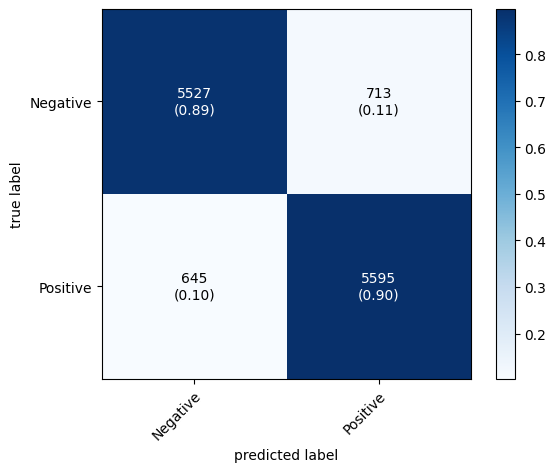

In [39]:
accuracy_fnn, precision_fnn, recall_fnn, f1_fnn = evaluate_model(model=model_fnn,
               test_dataset=onehot_dataset_test,
               device=device)

### RNN

In [33]:
class RNN(nn.Module):
  def __init__(self, vocab_size, embedding_shape, hidden_units, output_shape):
    super().__init__()
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_shape, padding_idx=0)
    self.rnn = nn.RNN(input_size=embedding_shape, hidden_size=hidden_units, batch_first=True,)
    self.fc = nn.Linear(hidden_units, output_shape)

  def forward(self, x):
    # x: [batch_size, seq_len]
    embedded = self.embedding(x)        # [batch_size, seq_len, embedding_dim]
    rnn_out, _ = self.rnn(embedded)     # [batch_size, seq_len, hidden_size]
    final_features = rnn_out[:, -1, :]  # [batch_size, hidden_size]
    return self.fc(final_features)      # [batch_size, 1]

In [34]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

model_rnn = RNN(vocab_size=len(review_vocab), embedding_shape=100, hidden_units=128, output_shape=1).to(device=device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params=model_rnn.parameters(), lr=0.001)

train_model(model=model_rnn, loss_fn=loss_fn, optimizer=optimizer, train_dataset=index_dataset_train, 
            test_dataset=index_dataset_test, device=device)

Epoch 0 | Train Loss 0.6964 | Train Accuracy 50.4030% | Test Loss 0.6988 | Test Accuracy 49.9119%
Epoch 1 | Train Loss 0.6955 | Train Accuracy 50.1895% | Test Loss 0.6948 | Test Accuracy 49.0064%
Epoch 2 | Train Loss 0.6954 | Train Accuracy 50.2108% | Test Loss 0.6961 | Test Accuracy 50.2083%
Epoch 3 | Train Loss 0.6951 | Train Accuracy 50.2775% | Test Loss 0.6996 | Test Accuracy 50.6330%
Epoch 4 | Train Loss 0.6952 | Train Accuracy 50.4830% | Test Loss 0.6958 | Test Accuracy 50.5128%
Epoch 5 | Train Loss 0.6951 | Train Accuracy 50.6271% | Test Loss 0.6948 | Test Accuracy 50.1362%
Epoch 6 | Train Loss 0.6951 | Train Accuracy 50.4403% | Test Loss 0.6935 | Test Accuracy 50.1282%
Epoch 7 | Train Loss 0.6957 | Train Accuracy 50.1868% | Test Loss 0.6951 | Test Accuracy 50.2003%
Epoch 8 | Train Loss 0.6955 | Train Accuracy 50.1628% | Test Loss 0.6938 | Test Accuracy 50.0321%
Epoch 9 | Train Loss 0.6950 | Train Accuracy 50.4323% | Test Loss 0.6984 | Test Accuracy 50.5769%


It seems this model shows sign of both underfitting and overfitting, try add bidirection and dropout.

In [35]:
class RNN(nn.Module):
  def __init__(self, vocab_size, embedding_shape, hidden_units, output_shape):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_shape, padding_idx=0)
    self.rnn = nn.RNN(embedding_shape, hidden_units, batch_first=True, bidirectional=True)
    self.dropout = nn.Dropout(0.5)
    self.fc = nn.Linear(hidden_units * 2, output_shape)

  def forward(self, x):
    embedded = self.embedding(x)
    rnn_out, _ = self.rnn(embedded)
    final_features = self.dropout(rnn_out[:, -1, :])
    return self.fc(final_features)

In [36]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

model_rnn = RNN(vocab_size=len(review_vocab), embedding_shape=100, hidden_units=128, output_shape=1).to(device=device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params=model_rnn.parameters(), lr=0.001)

train_model(model=model_rnn, loss_fn=loss_fn, optimizer=optimizer, train_dataset=index_dataset_train, 
            test_dataset=index_dataset_test, device=device)

Epoch 0 | Train Loss 0.6964 | Train Accuracy 50.3843% | Test Loss 0.6932 | Test Accuracy 51.1779%
Epoch 1 | Train Loss 0.6956 | Train Accuracy 50.7979% | Test Loss 0.6960 | Test Accuracy 51.6186%
Epoch 2 | Train Loss 0.6945 | Train Accuracy 50.8940% | Test Loss 0.6981 | Test Accuracy 50.6811%
Epoch 3 | Train Loss 0.6926 | Train Accuracy 50.5124% | Test Loss 0.7005 | Test Accuracy 48.8381%
Epoch 4 | Train Loss 0.6883 | Train Accuracy 51.8627% | Test Loss 0.7006 | Test Accuracy 50.9054%
Epoch 5 | Train Loss 0.6864 | Train Accuracy 51.8974% | Test Loss 0.7027 | Test Accuracy 50.9455%
Epoch 6 | Train Loss 0.6840 | Train Accuracy 51.9241% | Test Loss 0.7068 | Test Accuracy 51.2099%
Epoch 7 | Train Loss 0.6832 | Train Accuracy 51.8547% | Test Loss 0.7158 | Test Accuracy 51.0577%
Epoch 8 | Train Loss 0.6820 | Train Accuracy 51.8707% | Test Loss 0.7109 | Test Accuracy 50.3365%
Epoch 9 | Train Loss 0.6804 | Train Accuracy 52.0709% | Test Loss 0.7079 | Test Accuracy 51.3301%


Accuracy: 0.5135
Precision: 0.5125
Recall: 0.5504
F1-score: 0.5308


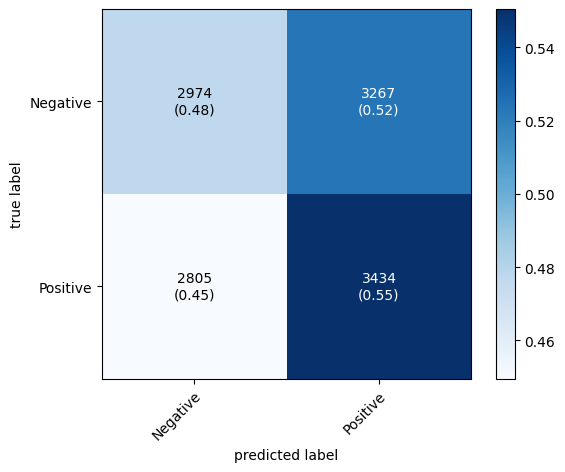

In [40]:
accuracy_rnn, precision_rnn, recall_rnn, f1_rnn = evaluate_model(model=model_rnn,
               test_dataset=index_dataset_test,
               device=device)

## GRU

In [41]:
class GRU(nn.Module):
  def __init__(self, vocab_size, embedding_shape, hidden_units, output_shape):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_shape, padding_idx=0)
    self.rnn = nn.GRU(embedding_shape, hidden_units, batch_first=True, bidirectional=True)
    self.dropout = nn.Dropout(0.5)
    self.fc = nn.Linear(hidden_units * 2, output_shape)

  def forward(self, x):
    embedded = self.embedding(x)
    rnn_out, _ = self.rnn(embedded)
    final_features = self.dropout(rnn_out[:, -1, :])
    return self.fc(final_features)

In [42]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

model_gru = GRU(vocab_size=len(review_vocab), embedding_shape=100, hidden_units=128, output_shape=1).to(device=device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params=model_gru.parameters(), lr=0.001)

train_model(model=model_gru, loss_fn=loss_fn, optimizer=optimizer, train_dataset=index_dataset_train, 
            test_dataset=index_dataset_test, device=device)

Epoch 0 | Train Loss 0.6937 | Train Accuracy 50.5177% | Test Loss 0.6932 | Test Accuracy 50.5769%
Epoch 1 | Train Loss 0.6898 | Train Accuracy 50.9554% | Test Loss 0.6954 | Test Accuracy 49.5513%
Epoch 2 | Train Loss 0.6805 | Train Accuracy 51.7667% | Test Loss 0.7003 | Test Accuracy 50.6250%
Epoch 3 | Train Loss 0.6675 | Train Accuracy 52.3911% | Test Loss 0.7080 | Test Accuracy 50.5128%
Epoch 4 | Train Loss 0.6594 | Train Accuracy 52.8635% | Test Loss 0.7210 | Test Accuracy 51.4022%
Epoch 5 | Train Loss 0.6203 | Train Accuracy 60.6880% | Test Loss 0.5311 | Test Accuracy 76.2821%
Epoch 6 | Train Loss 0.3906 | Train Accuracy 83.5958% | Test Loss 0.3760 | Test Accuracy 83.8141%
Epoch 7 | Train Loss 0.2633 | Train Accuracy 89.7443% | Test Loss 0.3468 | Test Accuracy 85.7051%
Epoch 8 | Train Loss 0.1866 | Train Accuracy 93.2990% | Test Loss 0.3783 | Test Accuracy 85.9295%
Epoch 9 | Train Loss 0.1227 | Train Accuracy 95.9837% | Test Loss 0.3915 | Test Accuracy 85.7692%


Accuracy: 0.8577
Precision: 0.8488
Recall: 0.8705
F1-score: 0.8595


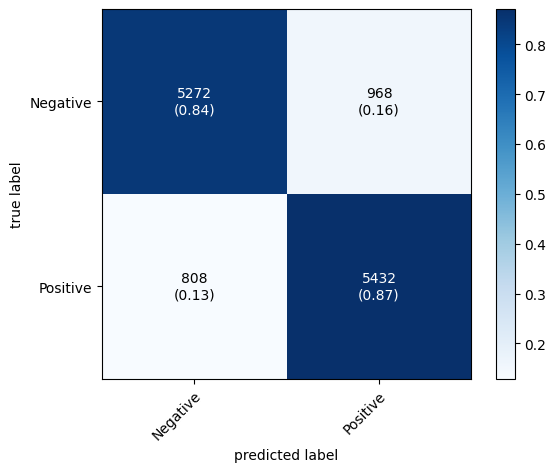

In [43]:
accuracy_gru, precision_gru, recall_gru, f1_gru = evaluate_model(model=model_gru,
               test_dataset=index_dataset_test,
               device=device)

## LSTM

In [44]:
class LSTM(nn.Module):
  def __init__(self, vocab_size, embedding_shape, hidden_units, output_shape):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_shape, padding_idx=0)
    self.rnn = nn.LSTM(embedding_shape, hidden_units, batch_first=True, bidirectional=True)
    self.dropout = nn.Dropout(0.5)
    self.fc = nn.Linear(hidden_units * 2, output_shape)

  def forward(self, x):
    embedded = self.embedding(x)
    rnn_out, _ = self.rnn(embedded)
    final_features = self.dropout(rnn_out[:, -1, :])
    return self.fc(final_features)

In [45]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

model_lstm = LSTM(vocab_size=len(review_vocab), embedding_shape=100, hidden_units=128, output_shape=1).to(device=device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params=model_lstm.parameters(), lr=0.001)

train_model(model=model_lstm, loss_fn=loss_fn, optimizer=optimizer, train_dataset=index_dataset_train, 
            test_dataset=index_dataset_test, device=device)

Epoch 0 | Train Loss 0.6932 | Train Accuracy 50.3069% | Test Loss 0.6933 | Test Accuracy 50.7051%
Epoch 1 | Train Loss 0.6907 | Train Accuracy 51.0221% | Test Loss 0.6950 | Test Accuracy 49.9279%
Epoch 2 | Train Loss 0.6861 | Train Accuracy 51.3583% | Test Loss 0.6957 | Test Accuracy 49.9840%
Epoch 3 | Train Loss 0.6665 | Train Accuracy 55.6869% | Test Loss 0.6759 | Test Accuracy 61.9631%
Epoch 4 | Train Loss 0.6567 | Train Accuracy 57.1227% | Test Loss 0.7066 | Test Accuracy 50.6490%
Epoch 5 | Train Loss 0.6304 | Train Accuracy 63.5808% | Test Loss 0.5941 | Test Accuracy 71.0737%
Epoch 6 | Train Loss 0.5665 | Train Accuracy 70.5006% | Test Loss 0.6564 | Test Accuracy 58.2612%
Epoch 7 | Train Loss 0.5009 | Train Accuracy 76.4784% | Test Loss 0.5027 | Test Accuracy 78.4856%
Epoch 8 | Train Loss 0.4195 | Train Accuracy 82.0506% | Test Loss 0.4478 | Test Accuracy 81.1298%
Epoch 9 | Train Loss 0.3668 | Train Accuracy 85.2130% | Test Loss 0.4294 | Test Accuracy 82.6042%


Accuracy: 0.8260
Precision: 0.8432
Recall: 0.8012
F1-score: 0.8217


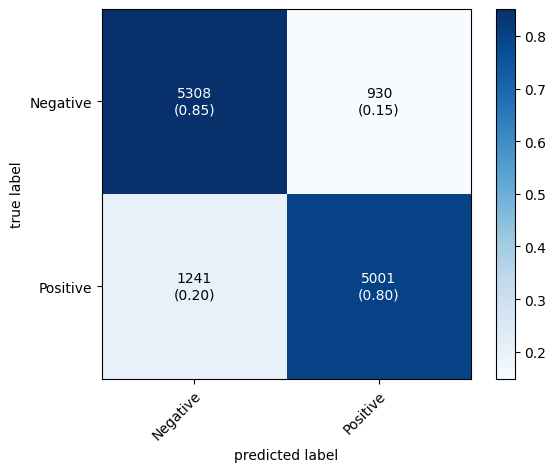

In [46]:
accuracy_lstm, precision_lstm, recall_lstm, f1_lstm = evaluate_model(model=model_lstm,
               test_dataset=index_dataset_test,
               device=device)

## Results

In [47]:
results = {
    "Model": ["FNN", "RNN", "GRU", "LSTM"],
    "Accuracy": [accuracy_fnn, accuracy_rnn, accuracy_gru, accuracy_lstm],
    "Precision": [precision_fnn, precision_rnn, precision_gru, precision_lstm],
    "Recall": [recall_fnn, recall_rnn, recall_gru, recall_lstm],
    "F1 Score": [f1_fnn, f1_rnn, f1_gru, f1_lstm]
}

metrics_df = pd.DataFrame(results)
metrics_df.round(4)

,Model,Accuracy,Precision,Recall,F1 Score
0,FNN,0.8912,0.8870,0.8966,0.8918
1,RNN,0.5135,0.5125,0.5504,0.5308
2,GRU,0.8577,0.8488,0.8705,0.8595
3,LSTM,0.8260,0.8432,0.8012,0.8217
